# Develop post-processing of radii

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import skeliner as sk
import numpy as np
from matplotlib import pyplot as plt

In [11]:
%timeit
mesh_path = './data/720575940536992435.obj'
mesh = sk.io.load_mesh(mesh_path)

In [12]:
%timeit
skel = sk.skeletonize(mesh=mesh)

In [13]:
%timeit
sk.post.calibrate_radii(skel=skel, points=mesh.vertices, verbose=True)

[skeliner] calibrate_radii – N=18203, fallback=0=0%, clamped=5240=29%, bimodal_nodes=587=3%; mode='centerline', store='calibrated', base='trim'


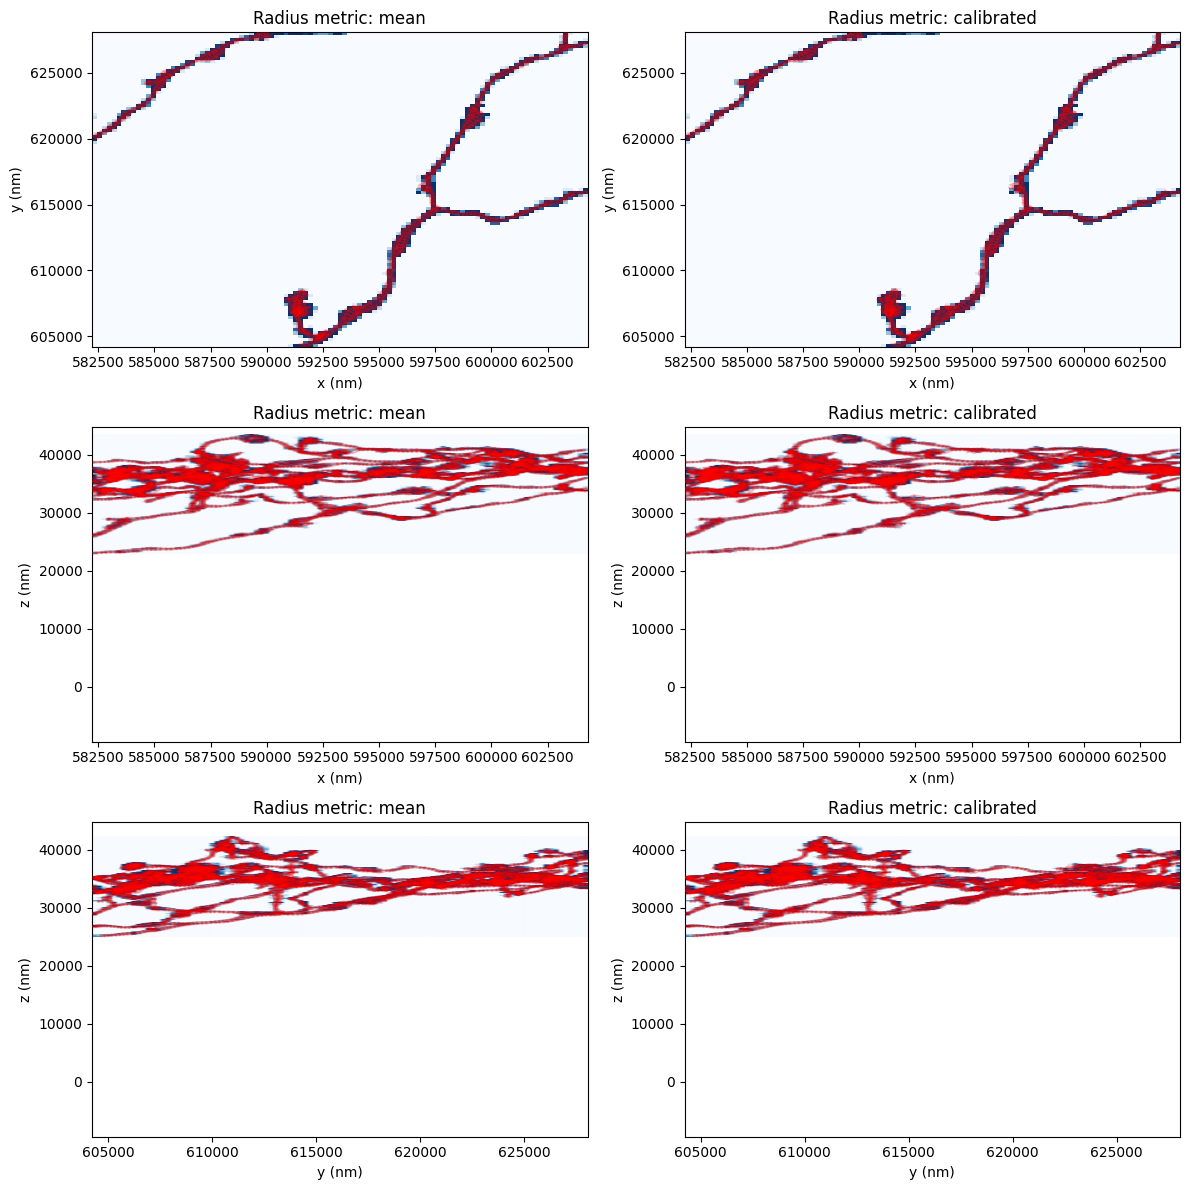

In [23]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
for i, metric in enumerate(['mean', 'calibrated']):
    x_rng = skel.nodes[:, 0].max() - skel.nodes[:, 0].min()
    y_rng = skel.nodes[:, 1].max() - skel.nodes[:, 1].min()
    z_rng = skel.nodes[:, 2].max() - skel.nodes[:, 2].min()

    xlim = skel.soma.center[0] - x_rng *0.05 + 0.1*x_rng, skel.soma.center[0] + x_rng *0.05 + 0.1*x_rng
    ylim = skel.soma.center[1] - y_rng *0.05 + 0.1*y_rng, skel.soma.center[1] + y_rng *0.05 + 0.1*y_rng
    zlim = skel.soma.center[2] - z_rng, skel.soma.center[2] + z_rng

    for j, plane in enumerate(['xy', 'xz', 'yz']):
        ax = axs[j, i]
        if plane == 'xy':
            xlim_j, ylim_j = xlim, ylim
        elif plane == 'xz':
            xlim_j, ylim_j = xlim, zlim
        elif plane == 'yz':
            xlim_j, ylim_j = ylim, zlim
        else:
            raise ValueError(f"Unknown plane: {plane}")

        sk.plot.projection(ax=ax, skel=skel, mesh=mesh, plane=plane, radius_metric=metric, draw_cylinders=True,
                           bins=101, xlim=xlim_j, ylim=ylim_j, cylinder_alpha=0.2)
        ax.set_aspect('auto', 'box')
        ax.set_title(f"Radius metric: {metric}")

plt.show()

In [15]:
(skel.soma.center / np.array([16, 16, 40])).astype(int)

array([35699, 37018,   440])

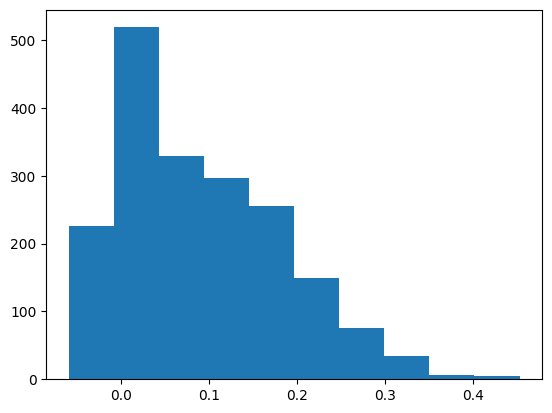

In [8]:
plt.hist((skel.radii['calibrated'] - skel.radii['mean']) / skel.radii['mean']);

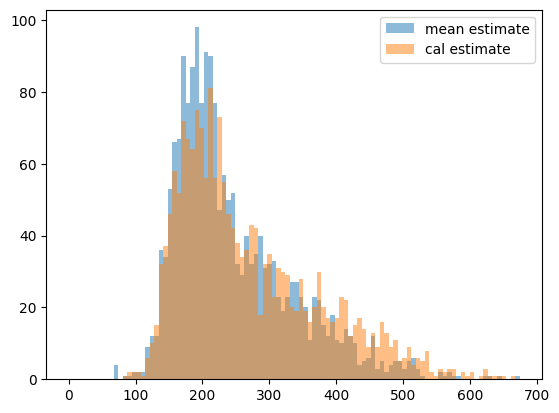

In [10]:
bins = np.linspace(0, np.max(skel.radii['mean']), 101)
plt.hist(skel.radii['mean'], alpha=0.5, bins=bins, label='mean estimate')
plt.hist(skel.radii['calibrated'], alpha=0.5, bins=bins, label='cal estimate')
plt.legend()
plt.show()